In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV


# Load the dataset
file_path = "THESIS_DENGUE-updated.csv"
df = pd.read_csv(file_path)

# Ensure dataset is sorted by year
df = df.sort_values(by=["Year", "Month"])


In [3]:
# Feature Engineering: Create Lag Features
df["Cases_Lag_1"] = df.groupby("Barangay")["Dengue Cases"].shift(1)
df["Cases_Lag_2"] = df.groupby("Barangay")["Dengue Cases"].shift(2)
df["Cases_Rolling_Mean"] = df.groupby("Barangay")["Dengue Cases"].rolling(3).mean().reset_index(level=0, drop=True)

In [4]:
# Convert Month into cyclical features
df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

In [5]:
# Define features and target variable
X = df.drop(columns=["No.", "Dengue Cases", "Barangay"])
y = df["Dengue Cases"]


In [6]:
# Split data based on year
train_mask = df["Year"].between(2011, 2016)
test_mask = df["Year"] == 2017

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

# Time-Based Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

In [7]:
# Hyperparameter tuning
params = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgboost_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
grid_search = GridSearchCV(xgboost_model, param_grid=params, cv=tscv, scoring="neg_mean_absolute_error", verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 2000, 'subsample': 1}


In [8]:
# Train final model with best parameters
best_model.fit(X_train, y_train)

y_pred = np.round(best_model.predict(X_test)).astype(int)


In [9]:
# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [10]:
# Get feature importance
importances = best_model.feature_importances_
features = X_train.columns
sorted_indices = importances.argsort()[::-1]
print("\nFeature Importance Ranking:")
for i in sorted_indices:
    print(f"{features[i]}: {importances[i]:.4f}")


Feature Importance Ranking:
Cases_Rolling_Mean: 0.5014
Rain: 0.1798
Cases_Lag_2: 0.1434
Cases_Lag_1: 0.0908
Temp: 0.0354
Hmd: 0.0151
y: 0.0114
Month: 0.0080
x: 0.0068
Month_cos: 0.0040
Year: 0.0020
Barangay_No: 0.0017
Month_sin: 0.0000


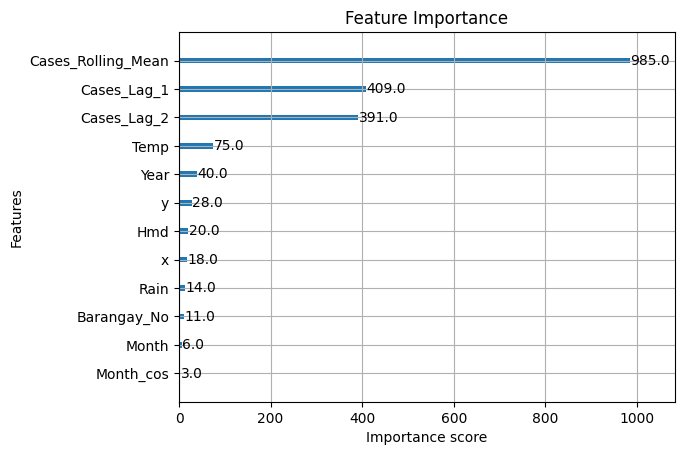

In [11]:
# Plot feature importance
xgb.plot_importance(best_model)
plt.title("Feature Importance")
plt.show()

In [12]:
# Save predictions
predictions_df = pd.DataFrame({
    "Barangay": df[test_mask]["Barangay"].values,
    "Actual Dengue Cases": y_test.values,
    "Predicted Dengue Cases": y_pred
})
predictions_df.to_csv("xgb_predictions.csv", index=False)

predictions_df["Error"] = abs(predictions_df["Actual Dengue Cases"] - predictions_df["Predicted Dengue Cases"])
print(predictions_df.sort_values("Error", ascending=False).head(10))



      Barangay  Actual Dengue Cases  Predicted Dengue Cases  Error
50       TUBOD                    8                      23     15
24       TUBOD                    1                      15     14
76       TUBOD                    8                      20     12
11       PALAO                   15                      12      3
6   HINAPLANON                    5                       8      3
35  HINAPLANON                    4                       6      2
25       TUBOD                   38                      37      1
39       PALAO                    4                       5      1
17    SANTIAGO                    7                       6      1
1      BURU-UN                    7                       6      1


In [13]:
# Print results
print("\nDengue Case Predictions per Barangay:")
print(predictions_df.head())

print("\nXGBoost Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Dengue Case Predictions per Barangay:
        Barangay  Actual Dengue Cases  Predicted Dengue Cases  Error
0  BAGONG SILANG                    5                       5      0
1        BURU-UN                    7                       6      1
2       DALIPUGA                    2                       2      0
3     DEL CARMEN                    1                       1      0
4     DEL CARMEN                    1                       1      0

XGBoost Model Evaluation:
Mean Absolute Error (MAE): 0.2835
Mean Squared Error (MSE): 3.0567
Root Mean Squared Error (RMSE): 1.7483
R² Score: 0.7237


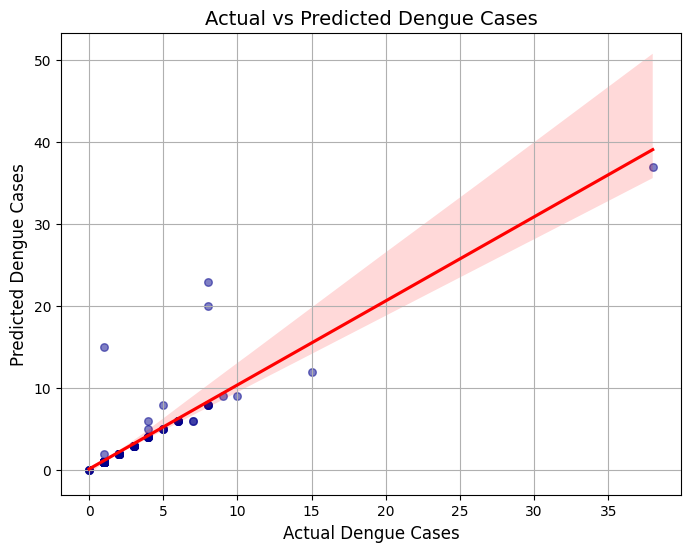

Predictions saved as 'xgb_predictions.csv'.


In [14]:
# Visualization
plt.figure(figsize=(8,6))
sns.regplot(x=y_test, y=y_pred, color="darkblue",
            scatter_kws={"alpha":0.5, "s":30}, line_kws={"color": "red"})
plt.xlabel("Actual Dengue Cases", fontsize=12)
plt.ylabel("Predicted Dengue Cases", fontsize=12)
plt.title("Actual vs Predicted Dengue Cases", fontsize=14)
plt.grid(True)
plt.show()

print("Predictions saved as 'xgb_predictions.csv'.")